# DDNet

This notebook contains the model definition, implementation and training for DDNet hand pose to gesture recognition model

Official: https://github.com/fandulu/DD-Net

## Prologue

In [1]:
from scipy.ndimage import interpolation as inter
from dataclasses import dataclass
from scipy.signal import medfilt
from keras.layers import *
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import random
import keras
import cv2
import os

In [2]:
random.seed(42069)

## Configuration

`num_frames` - Number of frames to be analysed, represented as $K$ in paper. Different from batch size.

`num_points` - Number of points in a frame, represented as $N$ in paper. DDnet uses 22 but we use 21.

`dim_point` - Dimension of one point. We use 3D points $(x, y, z)$.

`dim_jcd` - Dimension of JCD matrix after flattening. Value is given by $\binom{N}{2}$

`num_classes` - Number of classes to recognise. To be decided, but SHREC contains either 14 or 28 classes.

`filters` - Configurable number of filters to use in $Conv$ layers.

`dir_save` - Directory path to save model.

`dir_data` - Directory path to cleaned data, from SHREC format to Mediapipe format.

In [3]:
@dataclass
class Config:
    num_frames = 30
    num_points = 21
    dim_point = 3
    dim_jcd = 210
    num_classes = 14
    num_filters = 64
    dir_save = './model/'
    dir_data = './data/'
    
C = Config()

## Model

Reference: _Fan Yang, Sakriani Sakti, Yang Wu, & Satoshi Nakamura. (2020). Make Skeleton-based Action Recognition Model Smaller, Faster and Better._

#### Basic blocks

In [4]:
def c1D(x: tf.Tensor, filters: int, kernel: int) -> tf.Tensor:
    """ 1D Convolution for embeddings """
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [5]:
def c2x1D(x: tf.Tensor, filters: int) -> tf.Tensor:
    """ 2 x 1D Convolutions after concatenation """
    x = c1D(x, filters, 3)
    x = c1D(x, filters, 3)
    return x

In [6]:
def d1D(x: tf.Tensor, filters: int) -> tf.Tensor:
    """ FC layer """
    x = Dense(filters, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

#### Fast and slow motion

In [7]:
@tf.function
def poses_diff(x: tf.Tensor) -> tf.Tensor:
    """ Calculate difference between poses for a buffer """
    H, W = x.get_shape()[1], x.get_shape()[2]
    x = tf.subtract(x[:, 1:, ...], x[:, :-1, ...])
    x = tf.image.resize(x, size=(H, W, ))
    return x

class SlowMotion(Layer):
    def __init__(self, num_frames: int):
        super(SlowMotion, self).__init__()
        self.num_frames = num_frames
        
    def get_config(self):
        return {"num_frames": self.num_frames}
    
    def call(self, inputs):
        M_diff_slow = poses_diff(inputs)
        
        ps = inputs.shape[2] * inputs.shape[3]
        M_diff_slow = tf.reshape(M_diff_slow, (-1, self.num_frames, ps, ))
        return M_diff_slow
    
class FastMotion(Layer):
    def __init__(self, num_frames: int):
        super(FastMotion, self).__init__()
        self.num_frames = num_frames
        
    def get_config(self):
        return {"num_frames": self.num_frames}
    
    def call(self, inputs):
        M_fast = inputs[:, ::2, ...]
        M_diff_fast = poses_diff(M_fast)
        
        ps = inputs.shape[2] * inputs.shape[3]
        M_diff_fast = tf.reshape(M_diff_fast, (-1, self.num_frames // 2, ps, ) )
        return M_diff_fast

#### JCD Preprocessing

In [8]:
class JCD(Layer):
    def __init__(self, num_frames: int, dim_jcd: int):
        super(JCD, self).__init__()
        self.num_frames = num_frames
        self.dim_jcd = dim_jcd
        
    def get_config(self):
        return {"num_frames": self.num_frames, "dim_jcd": self.dim_jcd}
        
    @tf.function
    def get_jcd(self, x: tf.Tensor) -> tf.Tensor:
        n = tf.reduce_sum(tf.square(x), 1)
        na = tf.reshape(n, [-1, 1])
        nb = tf.reshape(n, [1, -1])
        D = tf.sqrt(tf.maximum(na - 2*tf.matmul(x, x, False, True) + nb, 0.0))
        return D

    @tf.function
    def jcd_flatten(self, D: tf.Tensor) -> tf.Tensor:
        ones = tf.ones_like(D)
        mask_a = tf.linalg.band_part(ones, 0, -1) # Upper triangular matrix of 0s and 1s
        mask_b = tf.linalg.band_part(ones, 0, 0)  # Diagonal matrix of 0s and 1s
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) # Make a bool mask
        triu = tf.boolean_mask(D, mask)
        return triu

    @tf.function
    def jcd_frames(self, P: tf.Tensor) -> tf.Tensor:
        buf = tf.slice(P, [0, 0, 0], [self.num_frames, 21, 3])
        D = tf.map_fn(self.get_jcd, buf)
        J = tf.map_fn(self.jcd_flatten, D)
        return J

    def call(self, inputs):
        J = tf.map_fn(self.jcd_frames, inputs)
        J = tf.reshape(J, (-1, self.num_frames, self.dim_jcd, ))
        return J

#### Embedding blocks

In [9]:
def embed1(x: tf.Tensor, filters: int) -> tf.Tensor:
    """ Embedding mapper for JCD and Slow motion """
    x = c1D(x, filters*2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    return x

In [10]:
def embed2(x: tf.Tensor, filters: int) -> tf.Tensor:
    """ Embedding mapper for Fast motion, since half the temporal length """
    x = c1D(x, filters*2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3) 
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = SpatialDropout1D(0.1)(x)
    return x

In [11]:
def scale_tensor(x: tf.Tensor) -> tf.Tensor:
    y = tf.reduce_mean(x, axis = -1, keepdims = True)
    print(y.shape)
    z = tf.math.truediv(x, y)
    return z

#### Full model

In [12]:
def DDnet(C: Config) -> keras.Model:
    """ Builds DDnet model for given configuration """
    
    # Poses
    P = Input(shape=(C.num_frames, C.num_points, C.dim_point, ))

    # JCD
    J = JCD(C.num_frames, C.dim_jcd)(P)
    
    # Pose Motion
    M_fast = FastMotion(C.num_frames)(P)
    M_slow = SlowMotion(C.num_frames)(P)
    
    print(" Shapes of features ".center(35, '-'))
    print("Input: ".ljust(15), P.shape)
    print("JCD: ".ljust(15), J.shape)
    print("Fast diff: ".ljust(15), M_fast.shape)
    print("Slow diff: ".ljust(15), M_slow.shape)
    
    # Embeddings
    eta_jcd = embed1(J, C.num_filters)
    eta_slow = embed1(M_slow, C.num_filters)
    eta_fast = embed2(M_fast, C.num_filters)
    
    # Concatenate
    x = scale_tensor(concatenate([eta_jcd, eta_slow, eta_fast, ]))
#     x = concatenate([eta_jcd, eta_slow, eta_fast, ])

    # 2x Conv
    x = c2x1D(x, C.num_filters * 2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = c2x1D(x, C.num_filters * 4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = c2x1D(x, C.num_filters * 8)
    x = SpatialDropout1D(0.1)(x)
    
    # GAP
    x = GlobalMaxPooling1D()(x)

    # Learning
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = d1D(x, 128) # extra layer was in github repo
    x = Dropout(0.5)(x)
    
    x = Dense(C.num_classes)(x)
    x = Softmax()(x)
    
    return keras.Model(inputs=P, outputs=x, name='DDnet')

## Create Model

In [13]:
C = Config()
model = DDnet(C)

-------- Shapes of features -------
Input:          (None, 30, 21, 3)
JCD:            (None, 30, 210)
Fast diff:      (None, 15, 63)
Slow diff:      (None, 30, 63)
(None, 15, 1)


In [14]:
# Run a dummy input
P = np.ones((100, 30, 21, 3))
res = model(P)
res.shape

TensorShape([100, 14])

In [15]:
_DRAW = False

if _DRAW:
    keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [16]:
_SUMMARY = False

if _SUMMARY:
    model.summary()

## Load data

In [17]:
train = pickle.load(open(C.dir_data + 'train.pkl', 'rb'))
test = pickle.load(open(C.dir_data + 'test.pkl', 'rb'))

#### Preprocessing

In [18]:
def zoom(p, C: Config, target_l=30):
    """ Resize framerate to desired length """
    l = p.shape[0]
    p_new = np.empty([target_l, C.num_points, C.dim_point]) 
    for m in range(C.num_points):
        for n in range(C.dim_point):
            p[:, m, n] = medfilt(p[:, m, n], 3)
            p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]
    return p_new

In [19]:
def sampling_frame(p, C: Config):
    """ I don't know what this does """
    full_l = p.shape[0] # full length
    if random.uniform(0, 1) < 0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9, 1) * full_l)
        s = random.randint(0, full_l - int(valid_l))
        e = s + valid_l # sample end point
        p = p[int(s):int(e), :, :]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9, 1) * full_l)
        index = np.sort(np.random.choice(range(0, full_l), int(valid_l), replace=False))
        p = p[index, :, :]
    p = zoom(p, C)
    return p

In [20]:
def normalize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

In [21]:
_KEY_X = 'pose'
_KEY_Y = 'coarse_label'

X_train = list()
Y_train = list()
X_test = list()
Y_test = list()

for ds, X, Y in [ (train, X_train, Y_train), (test, X_test, Y_test) ]:
    for idx in tqdm(range(len(ds[_KEY_X]))):
        p = ds[_KEY_X][idx]
        p = np.reshape(p, (-1, 21, 3))
        p = zoom(p, C)
        p = normalize_range(p)
        
        l = np.zeros(C.num_classes)
        l[ds[_KEY_Y][idx] - 1] = 1
        
        X.append(p)
        Y.append(l)

X_train = np.stack(X_train)
Y_train = np.stack(Y_train)
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:06<00:00, 124.13it/s]


In [22]:
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

X_train:  (1960, 30, 21, 3)
Y_train:  (1960, 14)
X_test:  (840, 30, 21, 3)
Y_test:  (840, 14)


In [23]:
X_validation = list()
new_X_test = list()
Y_validation = list()
new_Y_test = list()

for t in range(0, X_test.shape[0] - 1, 2):
    X_validation.append(X_test[t])
    new_X_test.append(X_test[t+1])

for t in range(0, Y_test.shape[0] - 1, 2):
    Y_validation.append(Y_test[t])
    new_Y_test.append(Y_test[t+1])
    
X_test = np.array(new_X_test)
X_validation = np.array(X_validation)
Y_test = np.array(new_Y_test)
Y_validation = np.array(Y_validation)

print("X_test: ", X_test.shape)
print("X_validation: ", X_validation.shape)
print("Y_test: ", Y_test.shape)
print("Y_validation: ", Y_validation.shape)

X_test:  (420, 30, 21, 3)
X_validation:  (420, 30, 21, 3)
Y_test:  (420, 14)
Y_validation:  (420, 14)


## Training

#### Compile model

In [24]:
lr = 1e-3
min_lr = 1e-5
optim = keras.optimizers.Adam(lr)
loss = keras.losses.categorical_crossentropy
metrics = [ 'accuracy' ]

In [25]:
model.compile(optim, loss, metrics)

#### Callbacks

In [26]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    cooldown=5,
    min_lr=min_lr,
)

In [27]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None,
)

In [28]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#### Fitting

In [29]:
history = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=400,
    verbose=True,
    shuffle=True,
    callbacks=[ lr_scheduler, tb_callback, early_stopping, ],
    validation_data=(X_validation, Y_validation)
)

Epoch 1/400
62/62 [==============================] - 18s 206ms/step - loss: 2.6194 - accuracy: 0.2001 - val_loss: 3.4136 - val_accuracy: 0.1214
Epoch 2/400
62/62 [==============================] - 11s 184ms/step - loss: 1.2088 - accuracy: 0.6243 - val_loss: 5.5771 - val_accuracy: 0.0714
Epoch 3/400
62/62 [==============================] - 10s 167ms/step - loss: 0.7567 - accuracy: 0.7896 - val_loss: 3.8163 - val_accuracy: 0.1238
Epoch 4/400
62/62 [==============================] - 14s 226ms/step - loss: 0.5283 - accuracy: 0.8621 - val_loss: 4.4801 - val_accuracy: 0.1381
Epoch 5/400
62/62 [==============================] - 10s 164ms/step - loss: 0.5255 - accuracy: 0.8519 - val_loss: 2.5822 - val_accuracy: 0.3643
Epoch 6/400
62/62 [==============================] - 10s 160ms/step - loss: 0.4141 - accuracy: 0.8837 - val_loss: 1.4817 - val_accuracy: 0.6310
Epoch 7/400
62/62 [==============================] - 12s 201ms/step - loss: 0.3476 - accuracy: 0.9043 - val_loss: 0.8428 - val_accuracy:

In [30]:
model.save(C.dir_save)

INFO:tensorflow:Assets written to: ./model/assets


## Evaluate

In [31]:
labels = [ "Grab",
    "Tap",
    "Expand",
    "Pinch",
    "Rotate Clockwise",
    "Rotate Counter Clockwise",
    "Swipe Right",
    "Swipe Left",
    "Swipe Up",
    "Swipe Down",
    "Swipe X",
    "Swipe +",
    "Swipe V",
    "Shake",]

# labels = [
#     "Grab(1)",
#     "Grab(2)",
#     "Tap(1)",
#     "Tap(2)",
#     "Expand(1)",
#     "Expand(2)",
#     "Pinch(1)",
#     "Pinch(2)",
#     "Rotate Clockwise(1)",
#     "Rotate Clockwise(2)",
#     "Rotate Counter Clockwise(1)",
#     "Rotate Counter Clockwise(2)",
#     "Swipe Right(1)",
#     "Swipe Right(2)",
#     "Swipe Left(1)",
#     "Swipe Left(2)",
#     "Swipe Up(1)",
#     "Swipe Up(2)",
#     "Swipe Down(1)",
#     "Swipe Down(2)",
#     "Swipe X(1)",
#     "Swipe X(2)",
#     "Swipe +(1)",
#     "Swipe +(2)",
#     "Swipe V(1)",
#     "Swipe V(2)",
#     "Shake(1)",
#     "Shake(2)",
# ]


In [32]:
Y_pred = model.predict(X_test)

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [33]:
from sklearn import metrics
print(" Accuracy ---> ({0:.4f})".format(metrics.accuracy_score(y_true, y_pred)))

 Accuracy ---> (0.9595)


In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")


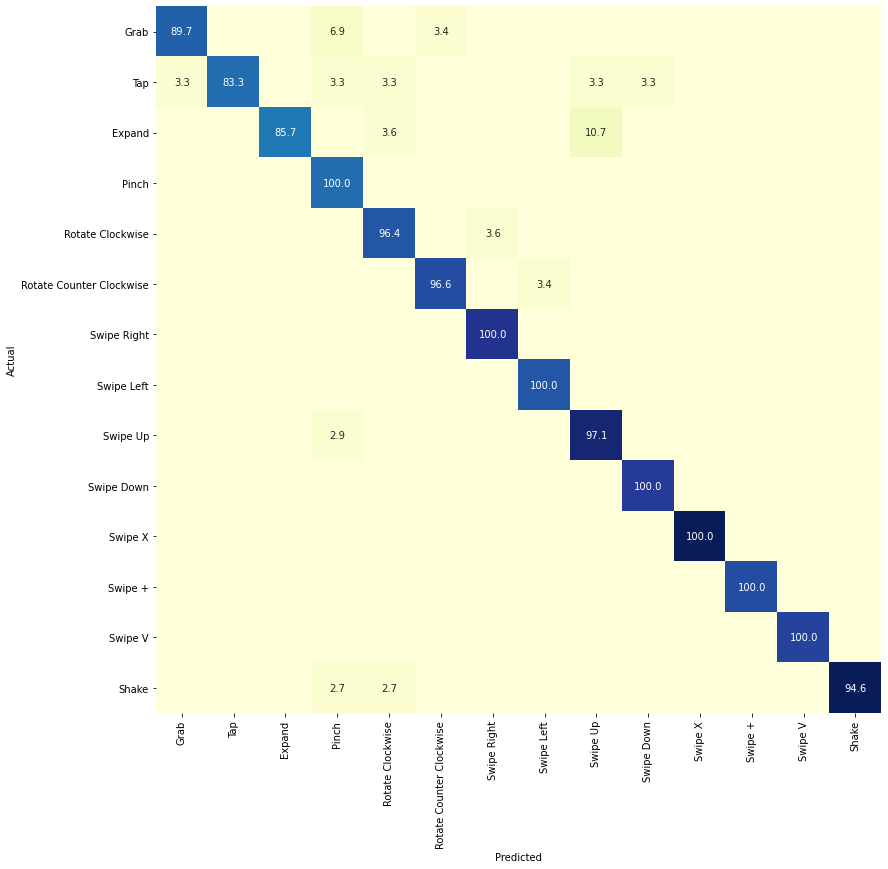

In [35]:
cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(13,13))

## Colab

#### Data

In [ ]:
!rm -rf ./sample_data
!mkdir ./data/
!gdown --id 1C2FsR99wzwBKaM-qSyVFAISMMkHnmRid -O ./data/test.pkl
!gdown --id 1LtWk9mrsF_iR-YJ8FQP8uXNstQNqke9d -O ./data/train.pkl

#### For downloading model and logs

In [ ]:
!zip -r model.zip ./model/

In [ ]:
!zip -r logs.zip ./logs/

#### Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs